In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(20)
from utils import roi_utils, default_paths, stats_utils

In [4]:
# Load results of the fitting procedure

subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_types = ['all_coco','all_coco_categ','semantic_coco_things_categ']

n_models = len(fitting_types)

outlist = []
for fi in range(n_models):
        
    out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_types[fi], \
                                      n_from_end=0, verbose=False) \
                                       for ss in subjects]
    outlist.append(out)
out = outlist

fig_save_folder=None


In [5]:
# initialize roi_def objects to get roi indices
skip_inds = [4,5,7,11,12, 19,20, 22, 24]
roi_def = roi_utils.multi_subject_roi_def(subjects, skip_areas=skip_inds)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

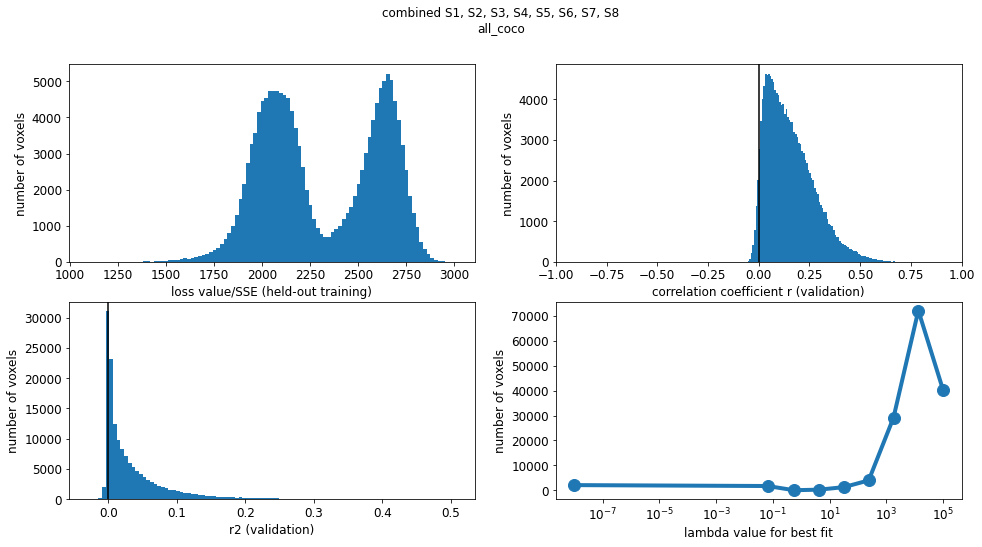

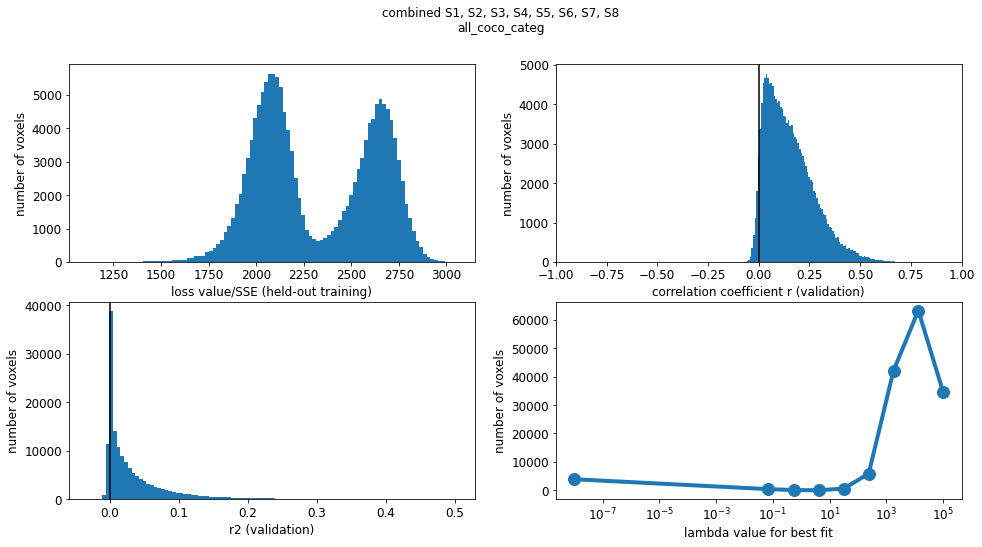

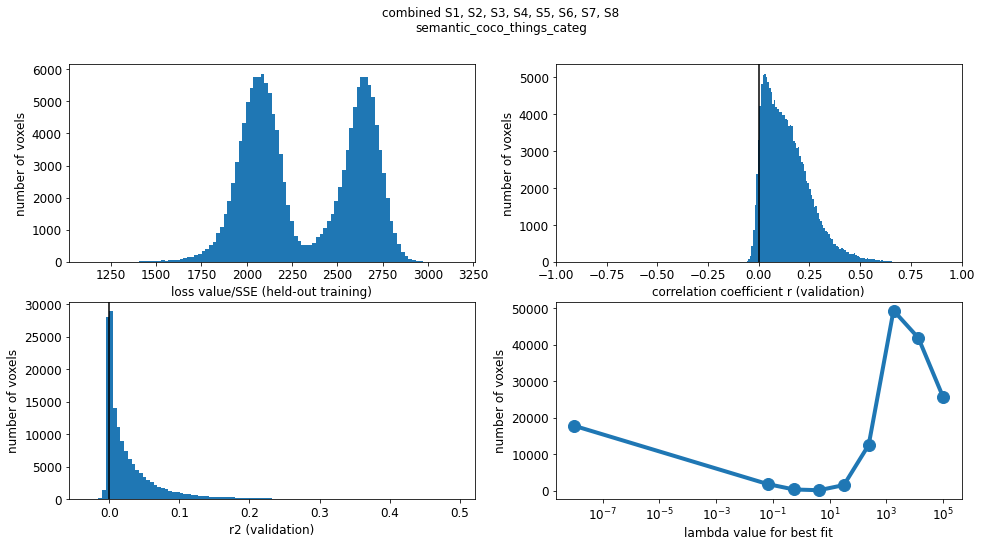

In [4]:
plot_utils.set_all_font_sizes(fs = 12)
for fi, fitting_type in enumerate(fitting_types):
    summary_plots.plot_perf_summary(fitting_type, out[fi], fig_save_folder=fig_save_folder)

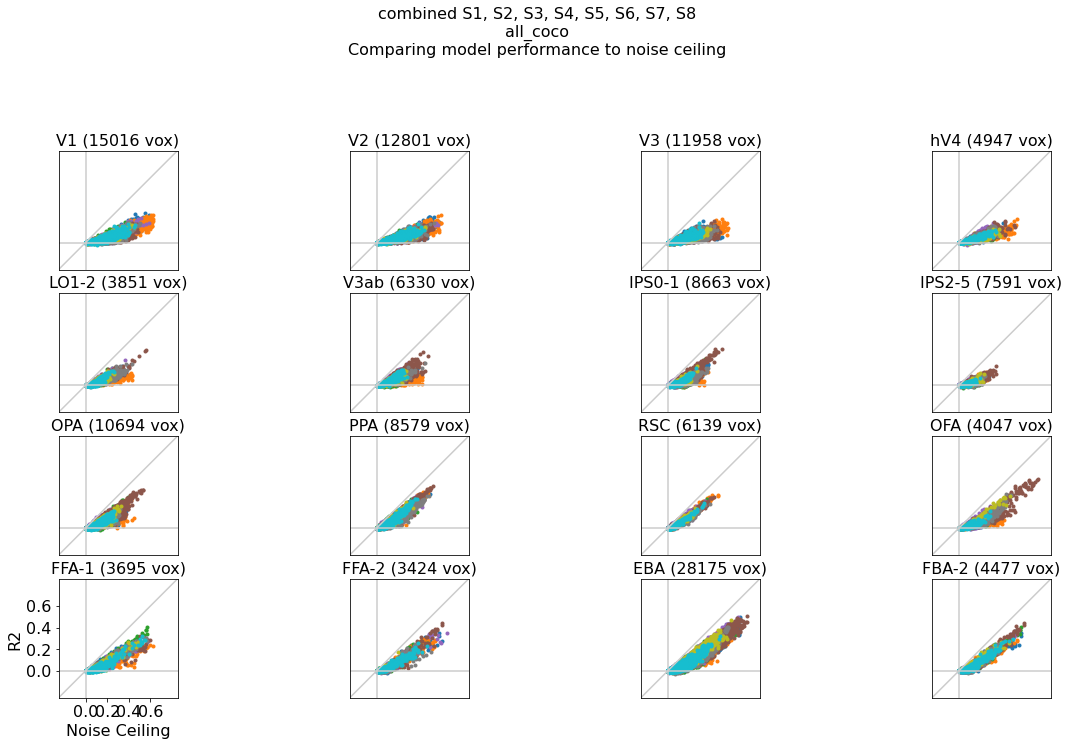

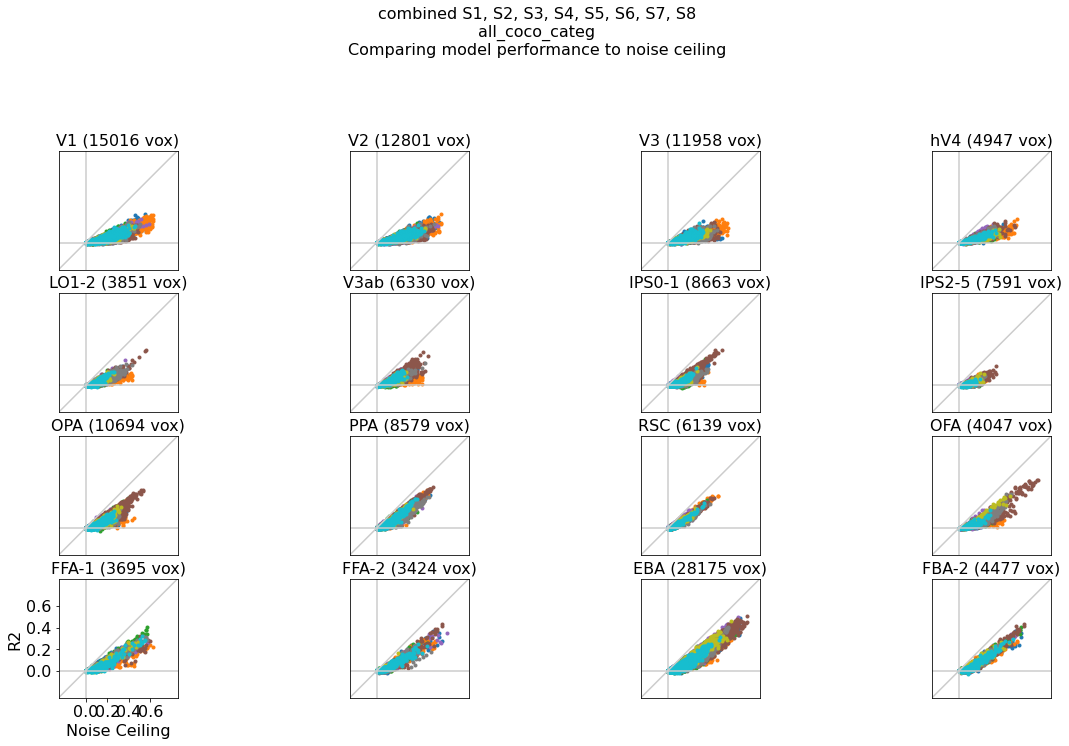

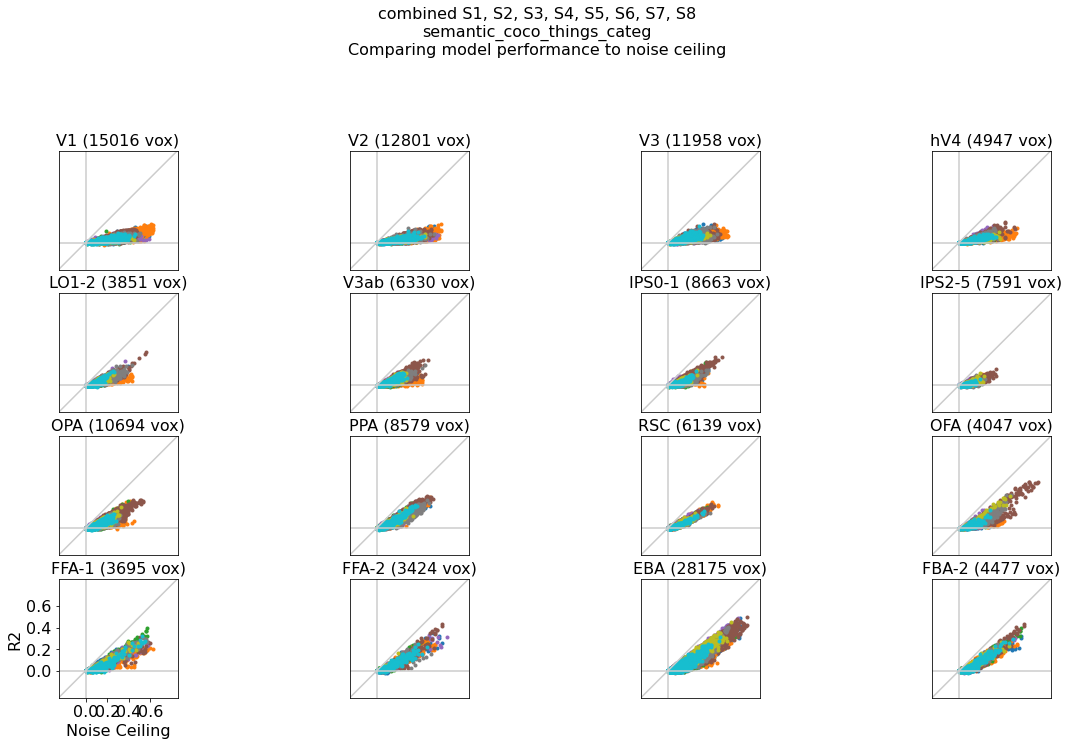

In [19]:
plot_utils.set_all_font_sizes(fs = 16)
colors = cm.tab10(np.linspace(0,1,8))
for fi, fitting_type in enumerate(fitting_types):
    fh = summary_plots.plot_r2_vs_nc(fitting_type,outlist[fi], roi_def=roi_def,\
                                axlims = [-0.25, 0.85], fig_save_folder=fig_save_folder, \
                                fig_size=(20,20), sub_colors=colors)

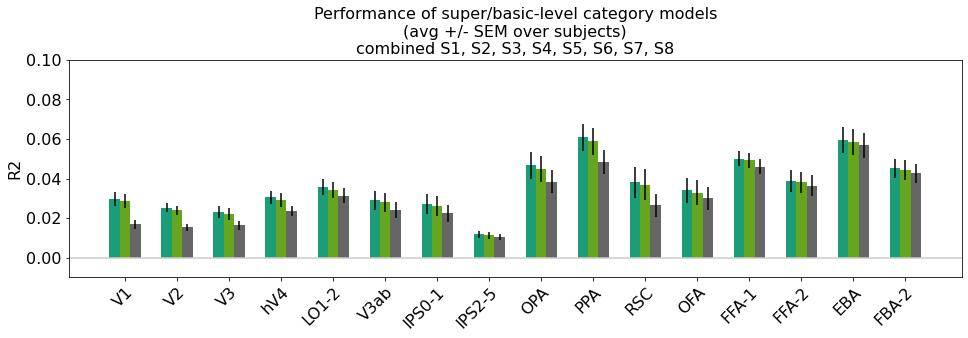

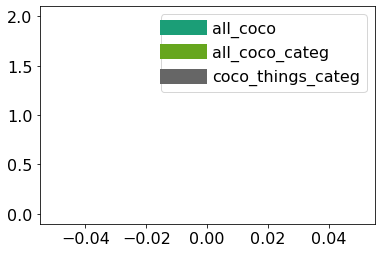

In [11]:
# plot mean performance each ROI

n_rois = roi_def.n_rois
roi_mean_vals = np.zeros((n_rois, n_models, n_subjects))

model_colors = cm.Dark2(np.linspace(0,1,n_models))

for si in range(n_subjects):

    for fi in range(n_models):

        vals = out[fi][si]['val_r2'][:,0]

        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri)

            roi_mean_vals[ri,fi,si] = np.mean(vals[inds_this_roi])

mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)
  
legend_separate=True
title = 'Performance of super/basic-level category models\n(avg +/- SEM over subjects)\n%s'\
    %summary_plots.get_substr(out[0])
names = [ft.split('semantic_')[1] if 'semantic' in ft else ft \
         for ft in fitting_types ]

plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=model_colors, space=0.3, \
                xticklabels=roi_names, ylabel='R2', \
                ylim=[-0.01, 0.10], title=title, horizontal_line_pos=0,\
                legend_labels=names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

    

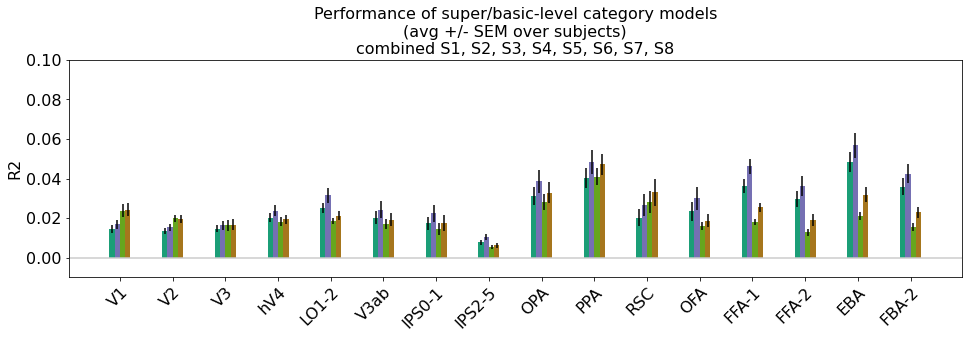

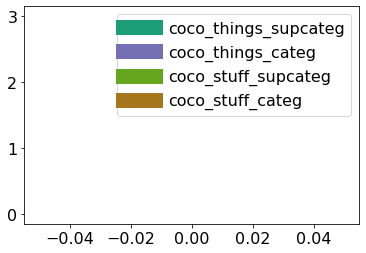

In [20]:
# plot mean performance each ROI

ppinds = [1,3,5,7]
names = [out[0][0]['partial_version_names'][pp].split('just_semantic_')[1] for pp in ppinds]

n_rois = roi_def.n_rois
roi_mean_vals = np.zeros((n_subjects, n_rois, len(ppinds)))

model_colors = cm.Dark2(np.linspace(0,1,5))

fi = 0;

for si in range(n_subjects):

    vals = out[fi][si]['val_r2'][:,ppinds]

    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri)

        roi_mean_vals[si,ri,:] = np.mean(vals[inds_this_roi,:], axis=0)

mean_vals = np.mean(roi_mean_vals, axis=0)
sem_vals = np.std(roi_mean_vals, axis=0)/np.sqrt(n_subjects)
  
legend_separate=True
title = 'Performance of super/basic-level category models\n(avg +/- SEM over subjects)\n%s'\
    %summary_plots.get_substr(out[0])

fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=model_colors, space=0.3, \
                xticklabels=roi_names, ylabel='R2', \
                ylim=[-0.01, 0.10], title=title, horizontal_line_pos=0,\
                legend_labels=names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

    

In [12]:
names

['all_coco', 'all_coco_categ', 'coco_things_categ']

In [8]:
ppinds = [1,3,5,7]
names = [out[0][0]['partial_version_names'][pp].split('just_semantic_')[1] for pp in ppinds]

['coco_things_supcateg',
 'coco_things_categ',
 'coco_stuff_supcateg',
 'coco_stuff_categ']

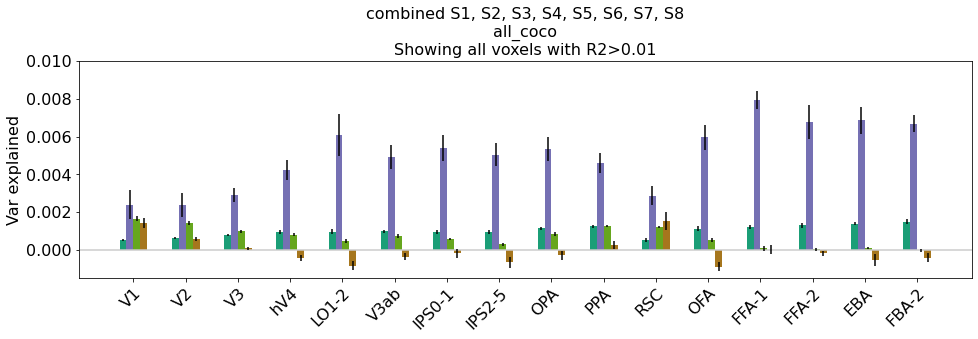

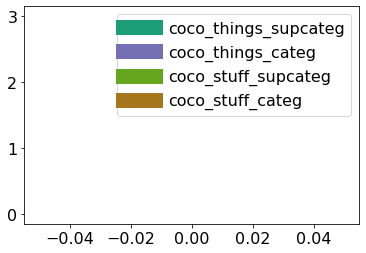

In [26]:
# Plot variance partition for the coco-all model 
# (things, stuff, super-ordinate, basic level)

mm = 0;
assert(fitting_types[mm] == 'all_coco')

r2_thresh = 0.01

# each of these indices is one feature set left out at a time.
ppinds = [2,4,6,8]
ve_names = [out[mm][0]['partial_version_names'][pp].split('leave_out_semantic_')[1] \
            for pp in ppinds]

colors = cm.Dark2(np.linspace(0,1,5))

n_rois = roi_def.n_rois
vals = np.zeros((n_subjects, n_rois, 4))

for si, ss in enumerate(subjects):
    
    val_r2 = out[mm][si]['val_r2']    
    inds2use = val_r2[:,0]>r2_thresh
    var_expl = np.tile(val_r2[:,0:1], [1,4]) - val_r2[:,ppinds]

    for ri in range(n_rois):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\n%s\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out[mm]), \
                                                   fitting_types[mm], r2_thresh)

plot_utils.set_all_font_sizes(fs = 16)
plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.3, \
                xticklabels=roi_names, ylabel='Var explained', \
                ylim=[-0.0015, 0.010], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))


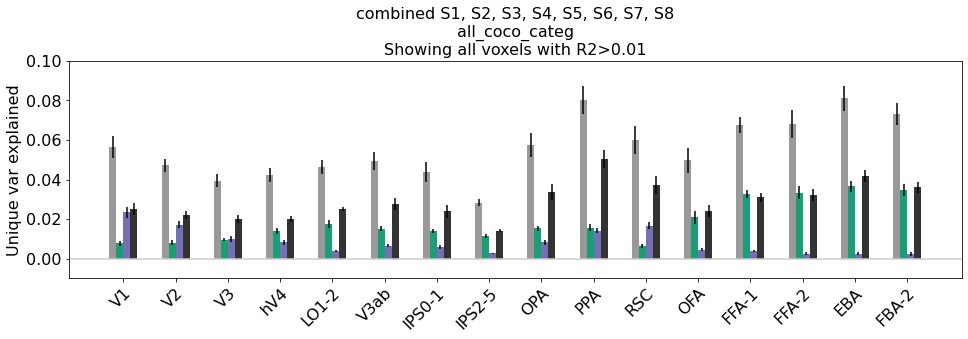

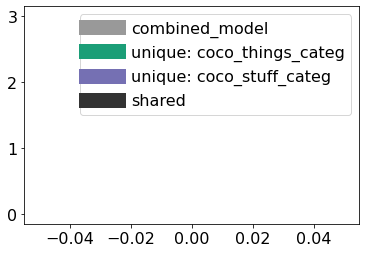

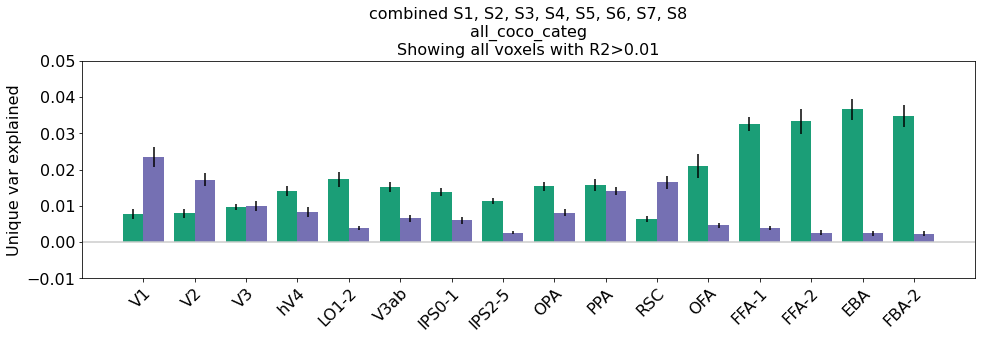

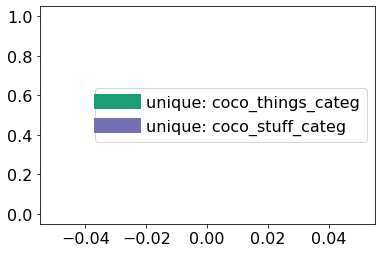

In [3]:
# Plot variance partition for the coco-all model 
# (things, stuff, super-ordinate, basic level)

mm = 1;
assert(fitting_types[mm] == 'all_coco_categ')

r2_thresh = 0.01

pp0 = 0
pp1 = 1
pp2 = 2

name1 = out[mm][0]['partial_version_names'][pp1].split('just_semantic_')[1]
name2 = out[mm][0]['partial_version_names'][pp2].split('just_semantic_')[1]

ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']

colors = cm.Dark2(np.linspace(0,1,5))
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[0,1],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

n_rois = roi_def.n_rois
vals = np.zeros((n_subjects, n_rois, 4))

for si, ss in enumerate(subjects):
    
    val_r2 = out[mm][si]['val_r2']    
    inds2use = val_r2[:,0]>r2_thresh
    shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], \
                                                                      val_r2[:,pp1],\
                                                                      val_r2[:,pp2])
    var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], \
                               unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

    for ri in range(n_rois):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\n%s\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out[mm]), \
                                                   fitting_types[mm], r2_thresh)

plot_utils.set_all_font_sizes(fs = 16)
plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.3, \
                xticklabels=roi_names, ylabel='Unique var explained', \
                ylim=[-0.010, 0.10], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

plot_utils.plot_multi_bars(mean_data=mean_vals[:,1:3], err_data=sem_vals[:,1:3], \
                           colors=colors[1:3,:], space=0.3, \
                xticklabels=roi_names, ylabel='Unique var explained', \
                ylim=[-0.010, 0.05], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names[1:3], \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

In [5]:
import cortex
from utils import numpy_utils

port=44442

title = 'Category-based models, %s'%(summary_plots.get_substr(out[0]));

names = []
maps = []
cmaps = []
mins = []
maxes = []
vox2plot = []
subject_map_inds = []
map_sequence = []

for si, ss in enumerate(subjects):
    
    for fi, fitting_type in enumerate(fitting_types):

        if 'semantic' in fitting_type:
            nn = fitting_type.split('semantic_')[1]
        else:
            nn = fitting_type
        names += ['S%d: %s (sqrt R2)'%(ss,nn)]
        maps += [np.sqrt(out[fi][si]['val_r2'][:,0])]
        cmaps += ['PuBu']
        mins += [0]
        maxes += [0.60]
        
    mm = 1
    assert(fitting_types[mm] == 'all_coco_categ')
    pp0 = 0
    pp1 = 1
    pp2 = 2
    name1 = out[mm][si]['partial_version_names'][pp1].split('just_semantic_')[1]
    name2 = out[mm][si]['partial_version_names'][pp2].split('just_semantic_')[1]
    val_r2 = out[mm][si]['val_r2']
    shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], \
                                                                      val_r2[:,pp1],\
                                                                      val_r2[:,pp2])

    max_ind = np.argmax(np.array([unique_a, unique_b]), axis=0).astype(np.float32)

    maps += [np.sqrt(unique_a)] + [np.sqrt(unique_b)] + [max_ind+1]
    names += ['S%d: unique var %s'%(ss,name1), 'S%d: unique var %s'%(ss,name2),\
              'S%d: Prefered feature type (based on unique var)'%(ss)]
    cmaps += ['PuBu', 'PuBu', 'plasma_r']
    mins += [0,0,0]
    maxes += [0.20, 0.20, 3]

    n_voxels = out[mm][si]['val_r2'].shape[0]
    vox2plot.append(np.ones((n_voxels,))==1)

    n_new_maps = int(len(names)/(si+1))
    subject_map_inds += [si for ii in range(n_new_maps)]
    map_sequence += [ni for ni in range(n_new_maps)]
    
# putting them into a nicer order (want same type of map near each other to compare subs)
_, new_order = numpy_utils.double_sort(np.arange(len(maps)), map_sequence, subject_map_inds)
names = [names[ni] for ni in new_order]
cmaps = [cmaps[ni] for ni in new_order]
mins = [mins[ni] for ni in new_order]
maxes = [maxes[ni] for ni in new_order]
maps = [maps[ni] for ni in new_order]
subject_map_inds = [subject_map_inds[ni] for ni in new_order]


voxel_mask = [o['voxel_mask'] for o in out[0]]
nii_shape = [o['brain_nii_shape'] for o in out[0]]
volume_space = out[0][0]['volume_space']

viewer = pycortex_plot_utils.plot_maps_pycortex(subjects, port, maps, names, subject_map_inds=subject_map_inds, \
                        mins=mins, maxes=maxes, cmaps=cmaps, \
                        title=title, vox2plot = vox2plot, roi_def=roi_def, simplest_roi_maps=True, \
                        voxel_mask =voxel_mask, \
                        nii_shape = nii_shape, \
                        volume_space=volume_space)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt


navigate browser to: 127.0.0.1:44442
Started server on port 44442
